In [1]:
# default_exp lightning.data

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
# export
import pandas as pd
import torch
from torch.utils.data import DataLoader
import albumentations as A
from omegaconf import DictConfig
from pytorch_lightning import LightningDataModule

from src.core import *

<IPython.core.display.Javascript object>

In [4]:
# export
class CassavaLightningDataModule(LightningDataModule):
    "lightning-datamodule for cassave leaf disease classification"

    def __init__(
        self,
        df_path: str,
        im_dir: str,
        curr_fold: int,
        default_config: DictConfig,
        train_augs: A.Compose = None,
        valid_augs: A.Compose = None,
        bs: int = 64,
        num_workers: int = 0,
    ):

        super().__init__()
        self.df = load_dataset(df_path, im_dir, curr_fold, True)
        self.train_augs = train_augs

        self.bs = bs
        self.workers = num_workers

        self.curr_fold = curr_fold
        self.im_dir = im_dir

        self.config = default_config

        if self.config.augmentations.backend == "custom":
            self.valid_augs = get_valid_transformations(self.config.augmentations.valid)
        else:
            self.valid_augs = valid_augs

    def prepare_data(self) -> None:
        self.train_df: pd.DataFrame = self.df.loc[self.df["is_valid"] == False]
        self.valid_df: pd.DataFrame = self.df.loc[self.df["is_valid"] == True]

        self.train_df = self.train_df.reset_index(inplace=False, drop=True)
        self.valid_df = self.valid_df.reset_index(inplace=False, drop=True)

    def setup(self, stage=None) -> None:
        if stage == "fit" or stage is None:
            if self.config.augmentations.backend == "custom":
                self.train_ds = FancyImageDataset(self.train_df, cfg=self.config)
                self.valid_ds = FancyImageDataset(self.valid_df, cfg=self.config, transforms=self.valid_augs)

            elif self.config.augmentations.backend == "albumentations":
                self.train_ds = ImageClassificationFromDf(self.train_df, self.train_augs)
                self.valid_ds = ImageClassificationFromDf(self.valid_df, self.valid_augs)

        if stage == "test" or stage is None:
            if self.config.augmentations.backend == "custom":
                self.test_ds = FancyImageDataset(self.valid_df, cfg=self.config, transforms=self.valid_augs)
            
            elif self.config.augmentations.backend == "albumentations":
                self.test_ds = ImageClassificationFromDf(self.valid_df, self.valid_augs)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_ds, shuffle=True, batch_size=self.bs, num_workers=self.workers,                                         pin_memory=True if torch.cuda.is_available() else False,)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.valid_ds, batch_size=self.bs, num_workers=self.workers,shuffle=False,
                         pin_memory=True if torch.cuda.is_available() else False,)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test_ds, batch_size=self.bs, num_workers=self.workers, 
                          shuffle=False, pin_memory=True if torch.cuda.is_available() else False,)

<IPython.core.display.Javascript object>

In [23]:
from hydra.experimental import compose, initialize, initialize_config_dir
from hydra.utils import instantiate
from torchvision.utils import make_grid
import matplotlib.pylab as plt

overrides = [
    "image_dims=120",
    "datamodule.bs=5",
    "datamodule.num_workers=0",
    "general=default",
    "trainer=fast-dev-cpu",
    "mixmethod=cutmix",
    "network=transferlearning",
    "augmentations=custom-augs",
    "augmentations.train.after_mix.auto_augment=original",
    "mixmethod.steps=1",
]

path = os.path.abspath('/Users/ayushman/Desktop/leaf-disease-classification-kaggle/conf')

with initialize_config_dir(path):
    cfg = compose(config_name="effnet-base", overrides=overrides)

<IPython.core.display.Javascript object>

In [14]:
def make_show_grid(dl):
    im, batch = next(iter(dl))
    grid = make_grid(im[:4], normalize=True).permute(1, 2, 0).data.numpy()
    plt.figure(figsize=(15, 15))
    plt.imshow(grid)

<IPython.core.display.Javascript object>

In [15]:
dm = CassavaLightningDataModule(
    df_path=cfg.general.csv_path,
    im_dir=cfg.general.image_dir,
    curr_fold=cfg.datamodule.curr_fold,
    default_config=cfg,
    bs=cfg.datamodule.bs,
    num_workers=cfg.datamodule.num_workers,
)

dm.prepare_data()
dm.setup()

<IPython.core.display.Javascript object>

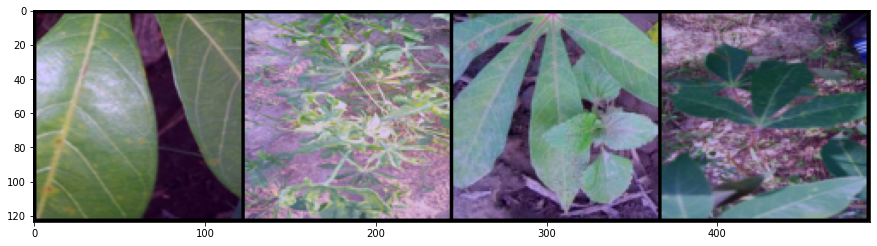

<IPython.core.display.Javascript object>

In [16]:
make_show_grid(dm.train_dataloader())

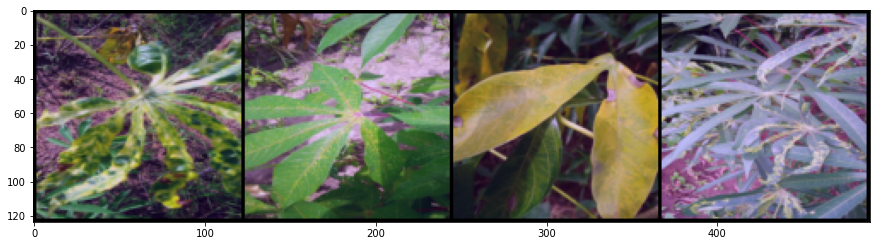

<IPython.core.display.Javascript object>

In [17]:
make_show_grid(dm.val_dataloader())

In [20]:
dm.train_ds.initial_tfms, dm.train_ds.curr_tfms, dm.train_ds.tfms

(Compose(
     RandomResizedCropAndInterpolation(size=(120, 120), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR PIL.Image.BICUBIC)
     RandomHorizontalFlip(p=0.5)
     RandomVerticalFlip(p=0.5)
     ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
     ToTensor()
     Normalize(mean=tensor([0.4298, 0.4962, 0.3130]), std=tensor([0.2142, 0.2191, 0.1954]))
 ),
 Compose(
     RandomResizedCropAndInterpolation(size=(120, 120), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR PIL.Image.BICUBIC)
     RandomHorizontalFlip(p=0.5)
     RandomVerticalFlip(p=0.5)
     ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
     ToTensor()
     Normalize(mean=tensor([0.4298, 0.4962, 0.3130]), std=tensor([0.2142, 0.2191, 0.1954]))
 ),
 Compose(
     RandomResizedCropAndInterpolation(size=(120, 120), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR PI

<IPython.core.display.Javascript object>

In [25]:
overrides = [
    "image_dims=120",
    "datamodule.bs=5",
    "datamodule.num_workers=0",
    "general=default",
    "trainer=fast-dev-cpu",
    "mixmethod=cutmix",
    "network=transferlearning",
    "augmentations=no-augs",
    "mixmethod.steps=10000000",
]

with initialize_config_dir(path):
    cfg = compose(config_name="effnet-base", overrides=overrides)

<IPython.core.display.Javascript object>

In [26]:
trn_augs = A.Compose([instantiate(a) for a in cfg.augmentations.train])
val_augs = A.Compose([instantiate(a) for a in cfg.augmentations.valid])

dm = CassavaLightningDataModule(
    df_path=cfg.general.csv_path,
    im_dir=cfg.general.image_dir,
    curr_fold=cfg.datamodule.curr_fold,
    default_config=cfg,
    bs=cfg.datamodule.bs,
    num_workers=cfg.datamodule.num_workers,
    train_augs=trn_augs,
    valid_augs=val_augs,
)

dm.prepare_data()
dm.setup()

<IPython.core.display.Javascript object>

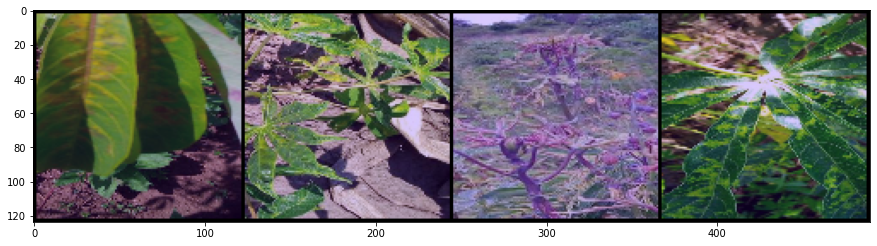

<IPython.core.display.Javascript object>

In [27]:
make_show_grid(dm.train_dataloader())

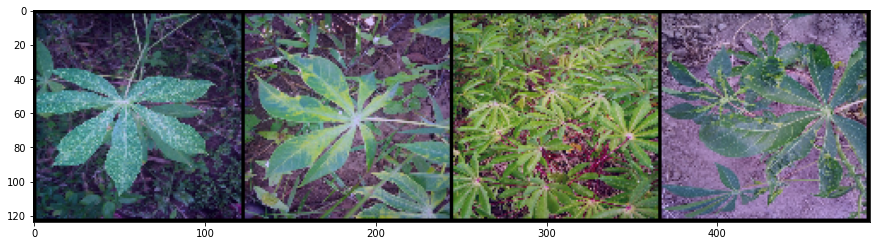

<IPython.core.display.Javascript object>

In [28]:
make_show_grid(dm.val_dataloader())

In [29]:
dm.train_augs, dm.valid_augs

(Compose([
   RandomResizedCrop(always_apply=False, p=1.0, height=120, width=120, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1),
   Resize(always_apply=False, p=1.0, height=120, width=120, interpolation=1),
   Normalize(always_apply=False, p=1.0, mean=[0.42984136, 0.49624753, 0.3129598], std=[0.21417203, 0.21910103, 0.19542212], max_pixel_value=255.0),
   ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
 Compose([
   Resize(always_apply=False, p=1.0, height=120, width=120, interpolation=1),
   Normalize(always_apply=False, p=1.0, mean=[0.42984136, 0.49624753, 0.3129598], std=[0.21417203, 0.21910103, 0.19542212], max_pixel_value=255.0),
   ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}))

<IPython.core.display.Javascript object>

In [31]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_mixmethods.ipynb.
Converted 02_losses.ipynb.
Converted 03_layers.ipynb.
Converted 03a_networks.ipynb.
Converted 04_optimizers_schedules.ipynb.
Converted 05_lightning.data.ipynb.
Converted 05a_lightning.core.ipynb.
Converted 05b_lightning.callbacks.ipynb.
Converted 06_fastai.core.ipynb.
Converted index.ipynb.


<IPython.core.display.Javascript object>